In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import data_generator
import ESPRIT
import QPE
import QCELS
import QMEGS

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def generate_ts_distribution(T,N,gamma):
    """ Generate time samples from truncated Gaussian
    Input:
    
    T : variance of Gaussian
    gamma : truncated parameter
    N : number of samples
    
    Output: 
    
    t_list: np.array of time points
    """
    t_list=truncnorm.rvs(-gamma, gamma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,population,T,N,gamma):
    """ Generate Z samples for a given T,N,gamma
    Input:
    
    spectrum: np.array of eigenvalues
    population: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    gamma : truncated parameter
    
    Output: 
    
    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,gamma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
    return Z_est, t_list, T_max, T_total

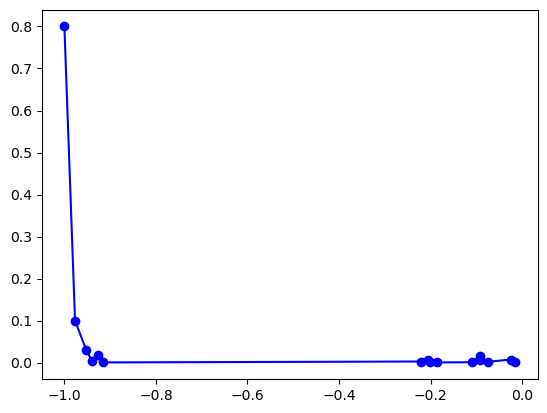

dominent gap= 0.02324231000729793


In [3]:
#Test Hubbard
L = 4
J = 1.0
U = 10.0
mu = 0.0
N_up = L // 2
N_down = L - N_up
p_list=np.array([0.8,0.1])
d=2**L

spectrum, population=data_generator.generate_initial_Hubbard(L,J,U,mu,N_up,N_down,p_list,d)
print('dominent gap=',spectrum[1]-spectrum[0])

In [4]:
N_rep=20 #number of different trying
N_rep_QPE=20
spectrum_per=np.zeros((len(spectrum),N_rep_QPE))
for n in range(N_rep_QPE):
   #random perturb to avoid coincidence
   spectrum_per[:,n]=spectrum+np.random.uniform(-1,1)*0.005

# Test QMEGS

In [10]:
T_list=np.array([200,400,800,1600,3200,6400,12800])
N=100
K_QMEGS=1
K_dominant=1
alpha=5
gamma=0.5
error_QMEGS=np.zeros(len(T_list),dtype='float')
T_total_QMEGS=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T_max=T_list[k]
        d_x=0.05/T_max
        Z_est,t_list, _, T_total = generate_Z(spectrum_per[:,n],population,T_max,N,gamma)
        T_total_QMEGS[k]+=sum(np.abs(t_list))
        output_energy = QMEGS.QMEGS_new(Z_est, d_x, t_list, K_QMEGS, alpha, T_max)
        output_energy = np.sort(output_energy)
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K_dominant):
                dominant_energy[l]=spectrum_per[index_list[l],n]
                error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_QMEGS[k]+=error_temp
        if n==0:
            print('Tmax=',gamma*T_max)
            print('Output of QMEGS energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_QMEGS=T_total_QMEGS/N_rep
error_QMEGS=error_QMEGS/N_rep

Tmax= 100.0
Output of QMEGS energy= [-1.00059265]
True dominant= [-1.00123912]
Tmax= 200.0
Output of QMEGS energy= [-1.00196765]
True dominant= [-1.00123912]
Tmax= 400.0
Output of QMEGS energy= [-1.00009265]
True dominant= [-1.00123912]
Tmax= 800.0
Output of QMEGS energy= [-1.00103015]
True dominant= [-1.00123912]
Tmax= 1600.0
Output of QMEGS energy= [-1.00120203]
True dominant= [-1.00123912]
Tmax= 3200.0
Output of QMEGS energy= [-1.00132703]
True dominant= [-1.00123912]
Tmax= 6400.0
Output of QMEGS energy= [-1.001245]
True dominant= [-1.00123912]


# Test QPE

In [11]:
T_list_QPE=np.array([400,1600,6400,25600,102400])
N_QPE=int(6/p_list[0])
error_QPE=np.zeros(len(T_list_QPE),dtype='float')
T_total_QPE=np.zeros(len(T_list_QPE),dtype='float')
for n in range(N_rep_QPE):
    for k in range(len(T_list_QPE)):
        T_max=T_list_QPE[k]
        output_energy = QPE.QPE(spectrum_per[:,n],population,T_max,N_QPE)
        T_total_QPE[k]+=T_max*N_QPE
        ##---measure error--##
        error_QPE[k]+=np.abs(spectrum_per[0,n]-output_energy)
        if n==0:
            print('Tmax=',T_max)
            print('Output of QPE energy=',output_energy)
            print('True ground=',spectrum_per[0,n])        
T_total_QPE=T_total_QPE/N_rep_QPE
error_QPE=error_QPE/N_rep_QPE

Tmax= 400
Output of QPE energy= -1.0053096491487334
True ground= -1.0012391202234046
Tmax= 1600
Output of QPE energy= -1.0013826583317464
True ground= -1.0012391202234046
Tmax= 6400
Output of QPE energy= -1.0013826583317464
True ground= -1.0012391202234046
Tmax= 25600
Output of QPE energy= -1.0013826583317464
True ground= -1.0012391202234046
Tmax= 102400
Output of QPE energy= -1.0015053767947775
True ground= -1.0012391202234046


# Test Kaiser-QPE

In [12]:
#Kaiser Window QPE
T_list_QPE=np.array([400,1600,6400,25600,102400])
N_K_QPE=int(4/p_list[0])
alpha=1
error_K_QPE=np.zeros(len(T_list_QPE),dtype='float')
T_total_K_QPE=np.zeros(len(T_list_QPE),dtype='float')
for n in range(N_rep_QPE):
    for k in range(len(T_list_QPE)):
        T_max=T_list_QPE[k]
        output_energy = QPE.Kaiser_QPE(spectrum_per[:,n],population,T_max,alpha,N_K_QPE)
        T_total_K_QPE[k]+=T_max*N_K_QPE
        ##---measure error--##
        error_K_QPE[k]+=np.abs(spectrum_per[0,n]-output_energy)
        if n==0:
            print('Tmax=',T_max)
            print('Output of QPE energy=',output_energy)
            print('True=',spectrum_per[0,n])        
T_total_K_QPE=T_total_K_QPE/N_rep_QPE
error_K_QPE=error_K_QPE/N_rep_QPE

Tmax= 400
Output of QPE energy= -1.0053096491487334
True= -1.0012391202234046
Tmax= 1600
Output of QPE energy= -1.0013826583317464
True= -1.0012391202234046
Tmax= 6400
Output of QPE energy= -1.0013826583317464
True= -1.0012391202234046
Tmax= 25600
Output of QPE energy= -1.0011372214056848
True= -1.0012391202234046
Tmax= 102400
Output of QPE energy= -1.0012599398687154
True= -1.0012391202234046


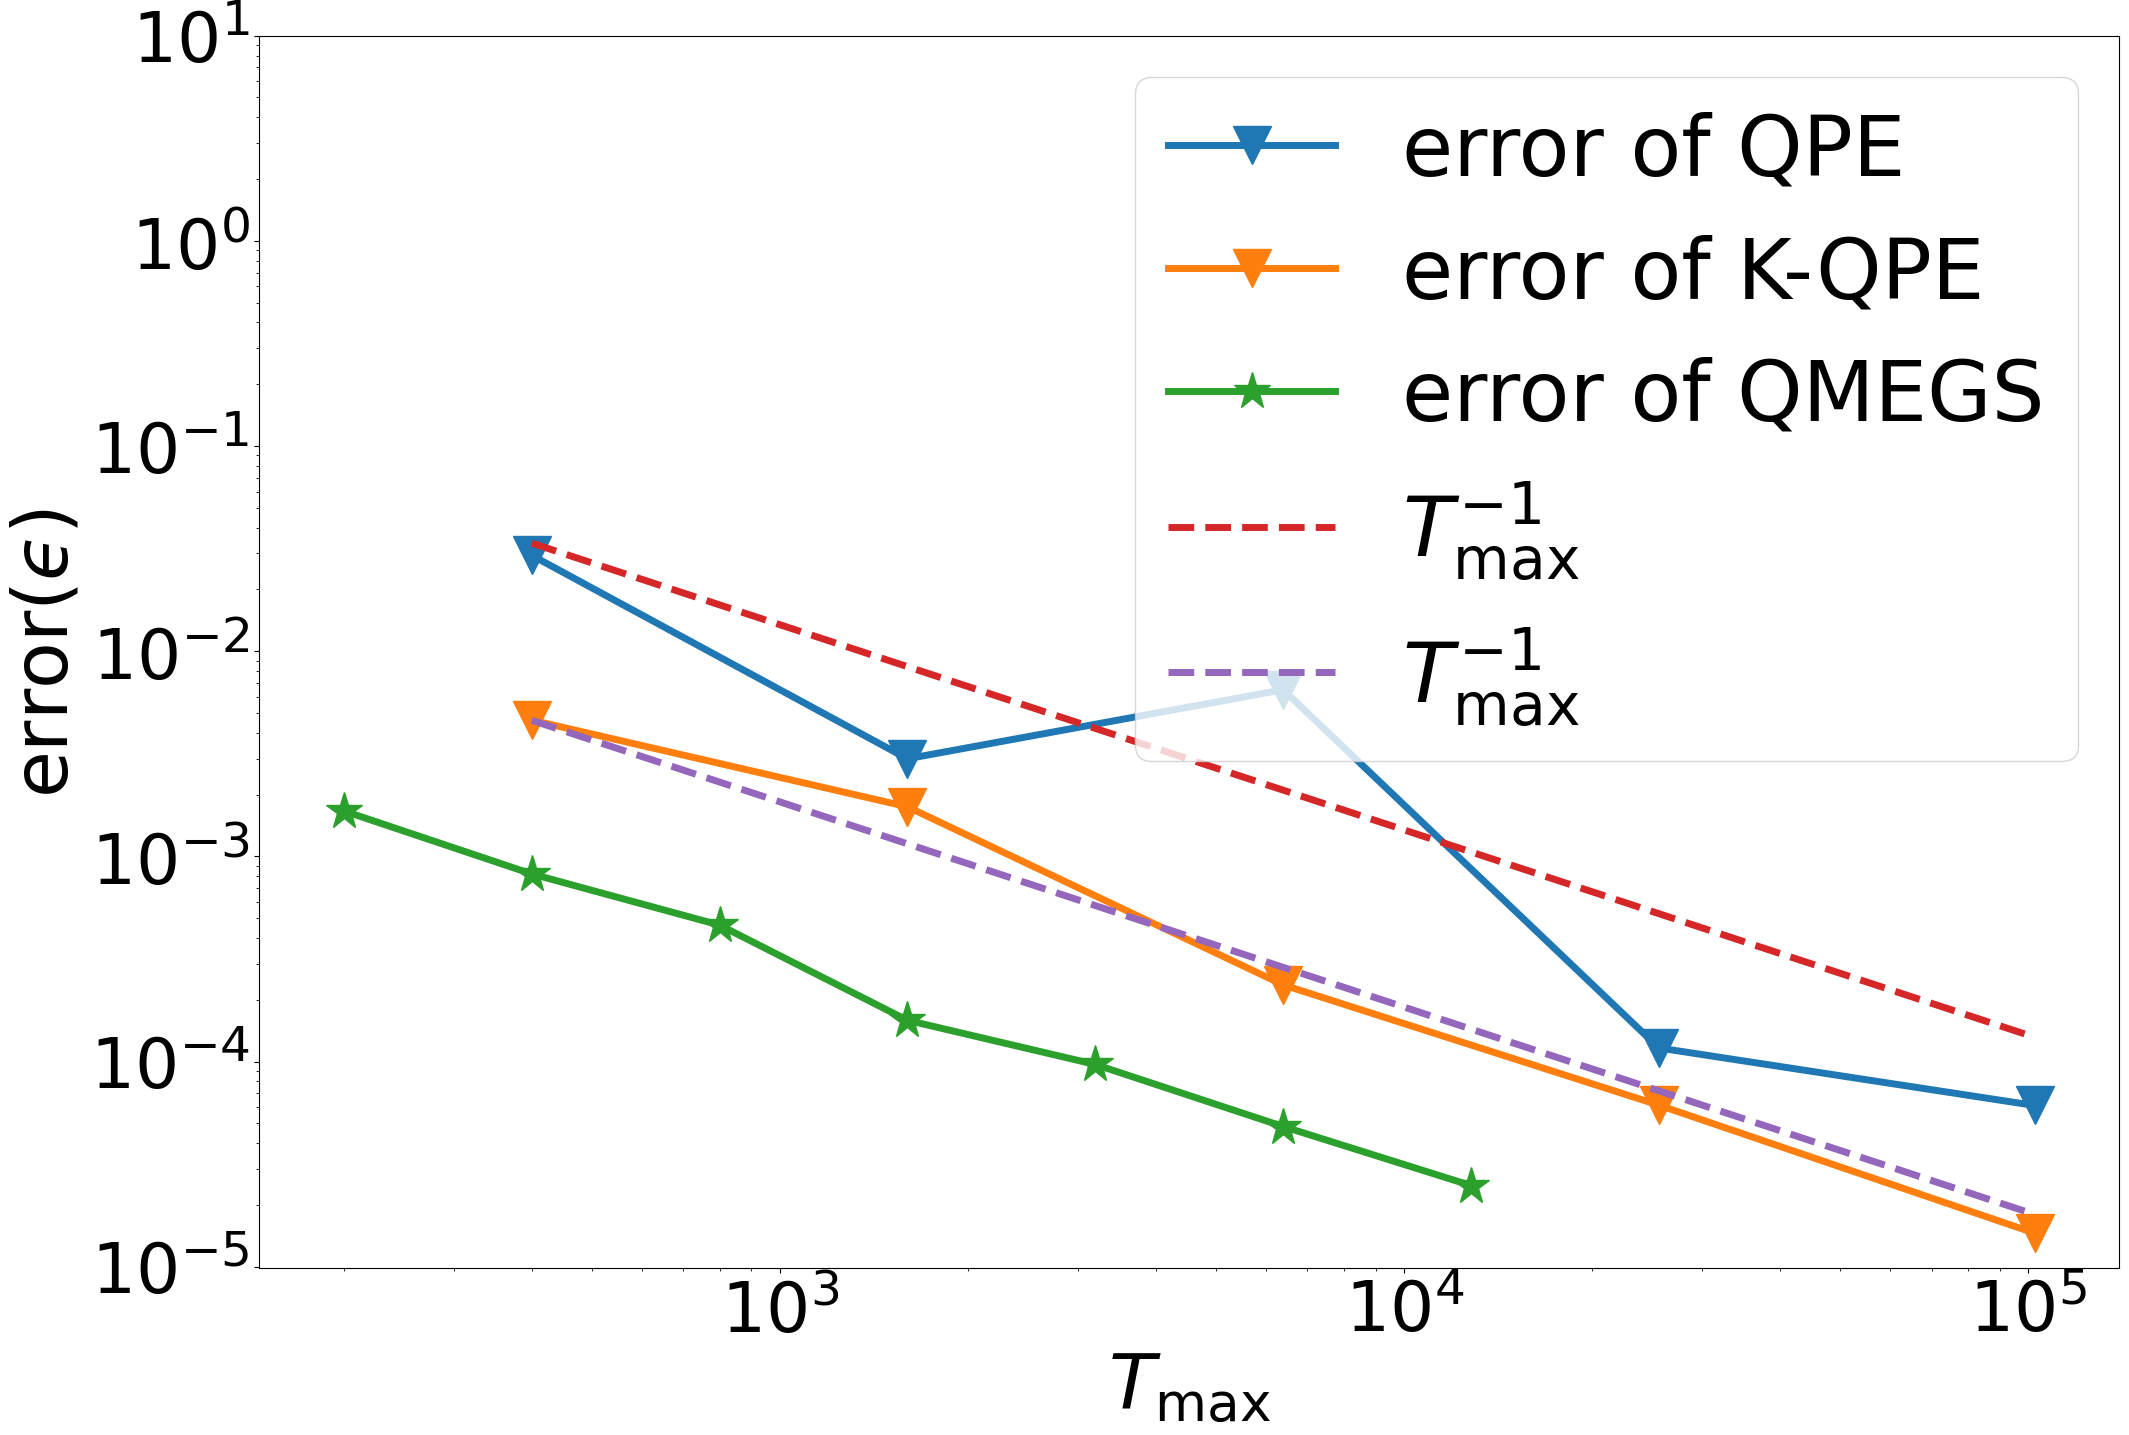

In [13]:
plt.figure(figsize=(24, 16))
plt.loglog(T_list_QPE, error_QPE, marker="v",markersize=28,
            linewidth=5, label='error of QPE')
plt.loglog(T_list_QPE, error_K_QPE, marker="v",markersize=28,
            linewidth=5, label='error of K-QPE')
plt.loglog(T_list, error_QMEGS, marker="*",markersize=28,
           linewidth=5, label='error of QMEGS')
plt.loglog(T_list_QPE, np.dot(error_QPE,T_list_QPE)/T_list_QPE/len(error_QPE), 
            '--', linewidth=5, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list_QPE, np.dot(error_K_QPE,T_list_QPE)/T_list_QPE/len(error_K_QPE), 
            '--', linewidth=5, label=r'$T_{\max}^{-1}$')
plt.xlabel("$T_{\max}$",fontsize=55)
plt.ylabel("error($ϵ$)",fontsize=55)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=60)
plt.savefig('Hubbard_T_max_k.pdf')

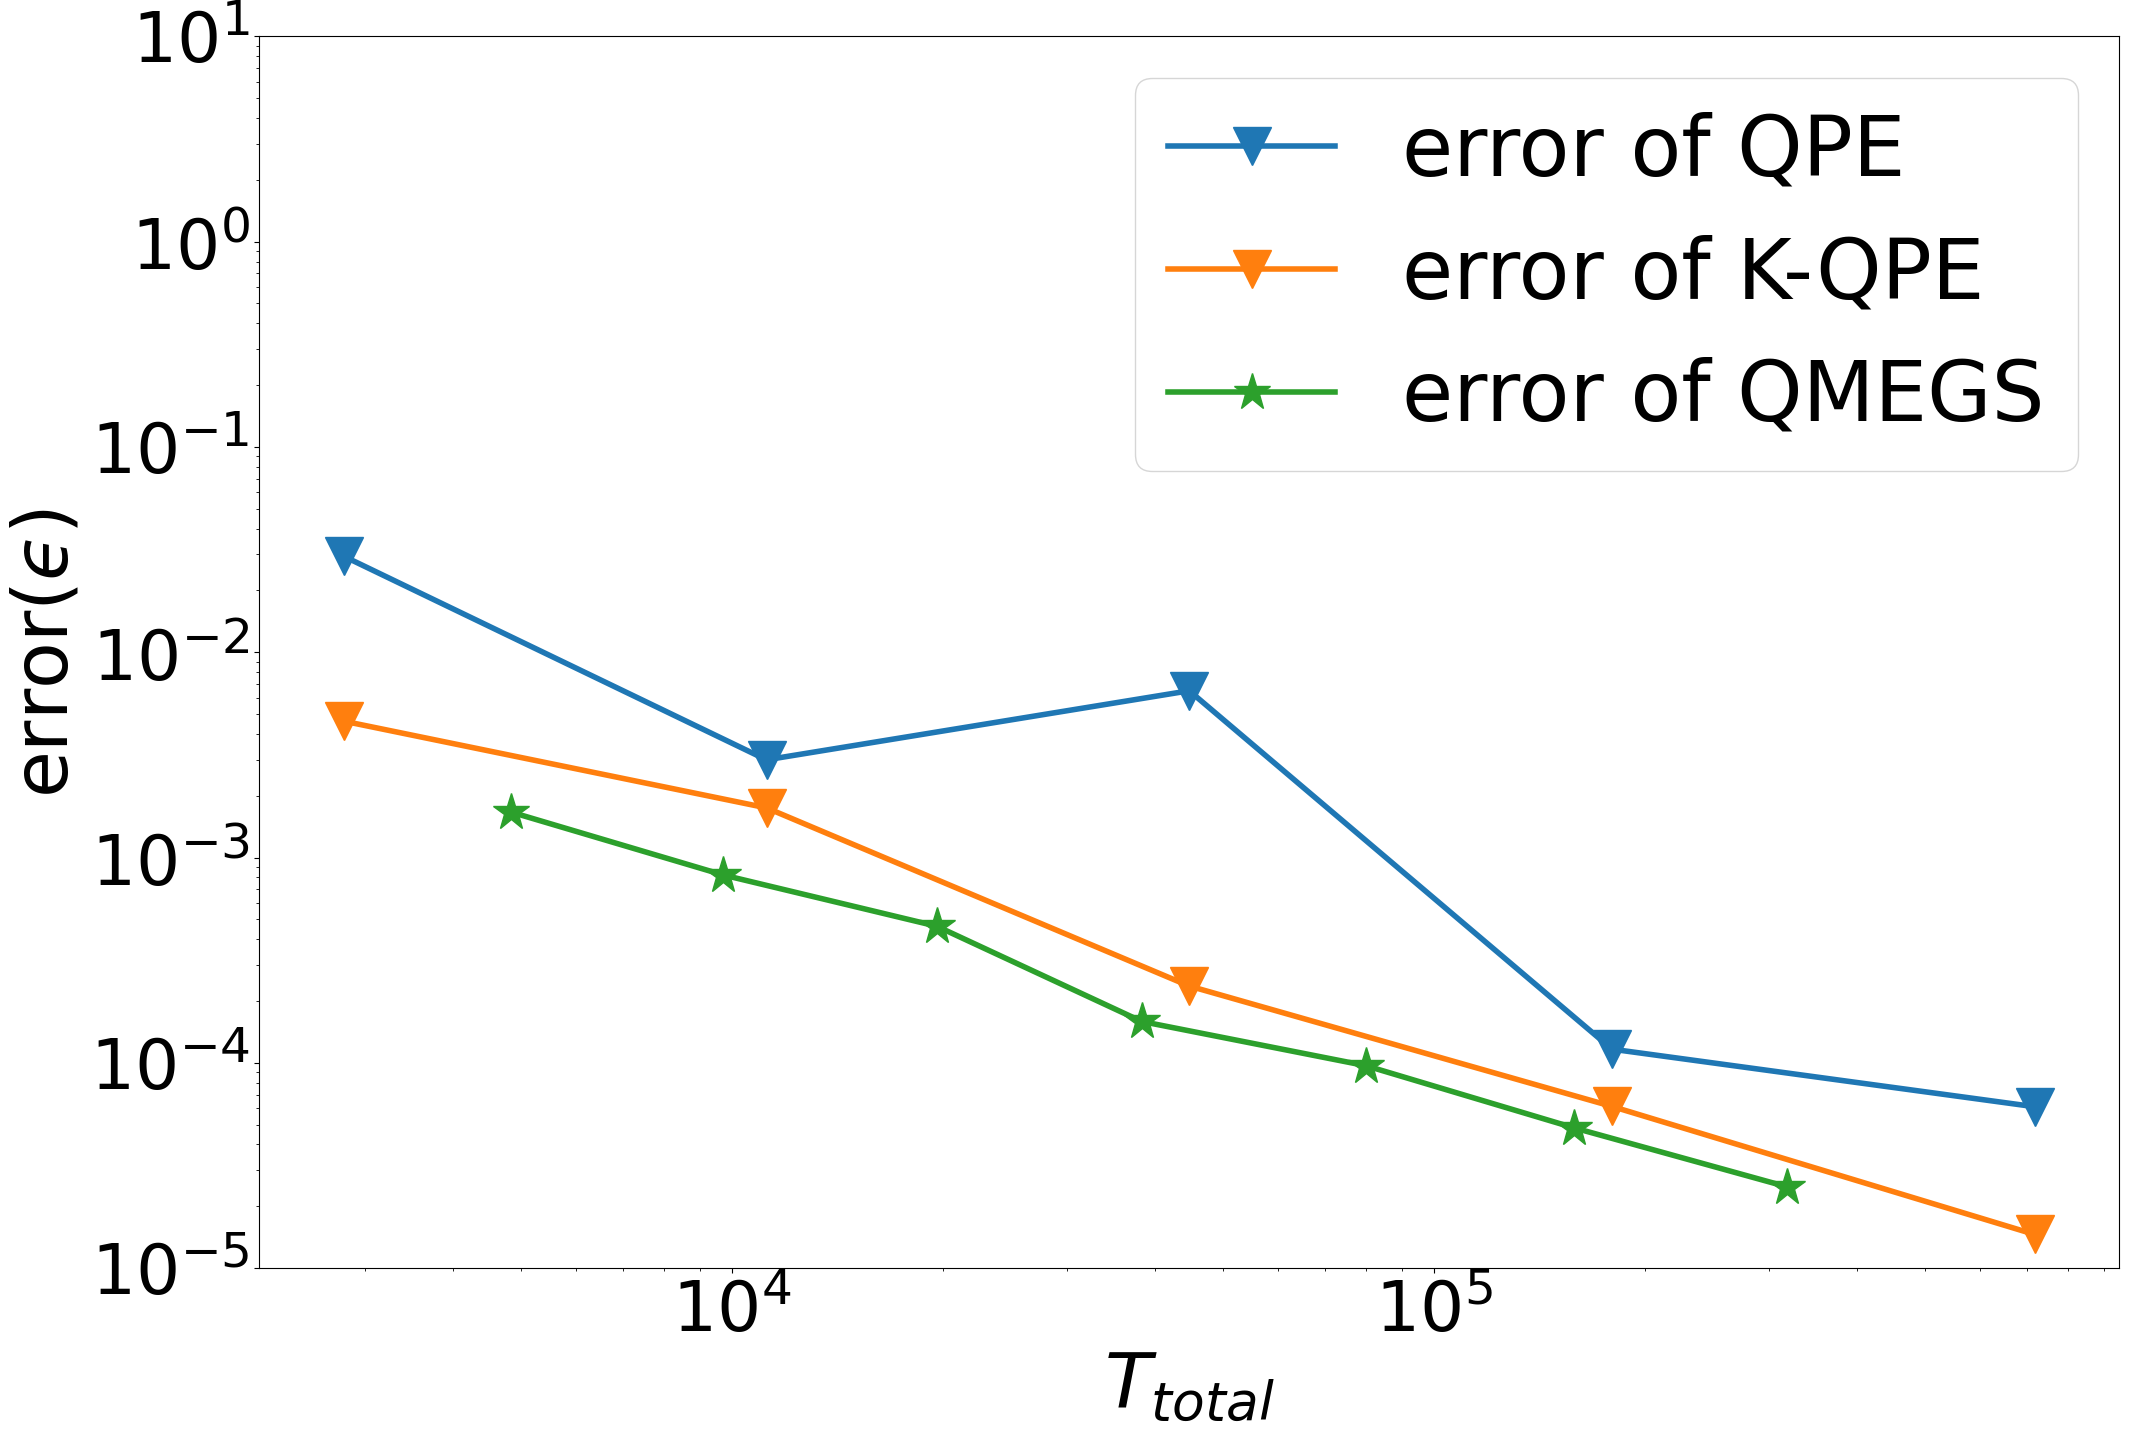

In [14]:
plt.figure(figsize=(24, 16))
plt.loglog(T_total_QPE, error_QPE, marker="v",markersize=28,
            linewidth=4, label='error of QPE')
plt.loglog(T_total_QPE, error_K_QPE, marker="v",markersize=28,
            linewidth=4, label='error of K-QPE')
plt.loglog(T_total_QMEGS, error_QMEGS, marker="*",markersize=28,
           linewidth=4, label='error of QMEGS')
plt.xlabel("$T_{total}$",fontsize=55)
plt.ylabel("error($ϵ$)",fontsize=55)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=60)
plt.savefig('Hubbard_T_total_ground.pdf')